In [8]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import readLHE
import invariants
import glob

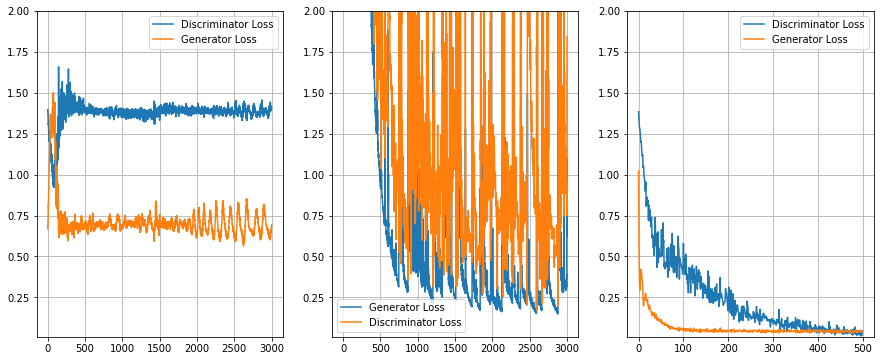

In [38]:
#failures
files = glob.glob('../mode_failures/loss*.txt')
labels = ['Discriminator Loss', 'Generator Loss']
losses = [np.loadtxt(files[i]) for i in range(len(files))]
fig, ax = plt.subplots(1,3, figsize=(15,6))
for i in range(len(files)):
    ax[i%3].plot(losses[i][:3000], label=labels[i%2])
    ax[i%3].set_ylim(0.01, 2.0)
    ax[i%3].grid(True)
    ax[i%3].legend()

In [4]:
#load models
generator = tf.keras.models.load_model('outputs/generator.h5')
discriminator = tf.keras.models.load_model('outputs/discriminator.h5')

In [5]:
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 200)               20200     
_________________________________________________________________
batch_normalization (BatchNo (None, 200)               800       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 200)               0         
_________________________________________________________________
reshape (Reshape)            (None, 10, 10, 2)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 10, 10, 64)        512       
_________________________________________________________________
batch_normalization_1 (Batch (None, 10, 10, 64)        256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 10, 10, 64)        0

In [6]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 200)               600       
_________________________________________________________________
batch_normalization_4 (Batch (None, 200)               800       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 200)               0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 10, 10, 2)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 10, 10, 64)        1216      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 10, 10, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 10, 10, 64)       

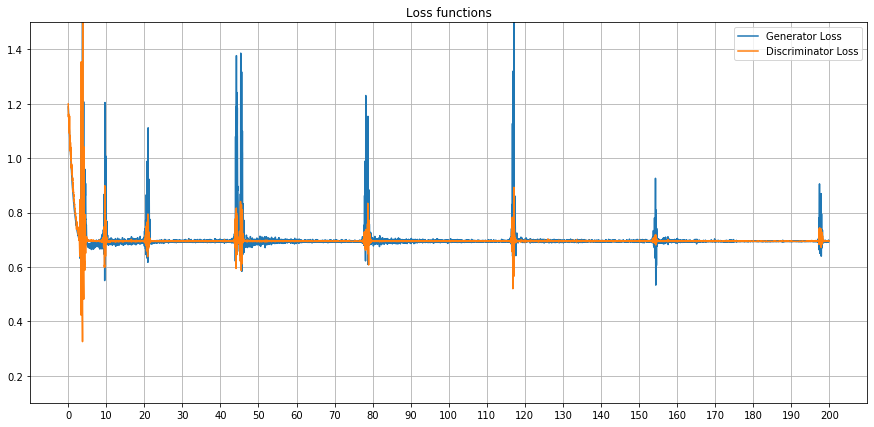

In [14]:
#losses
iter = 100
epochs = 200
d_loss = np.loadtxt('outputs/d_loss.txt')
g_loss = np.loadtxt('outputs/g_loss.txt')

plt.figure(figsize=(15,7))
plt.title('Loss functions')
plt.plot(g_loss, label='Generator Loss')
plt.plot(d_loss, label='Discriminator Loss')
plt.xticks(np.arange(0, len(d_loss)+1, 10*iter), np.arange(0, epochs+1, 10))
plt.ylim(0.1, 1.5)
plt.legend()
plt.grid(True)
plt.show()

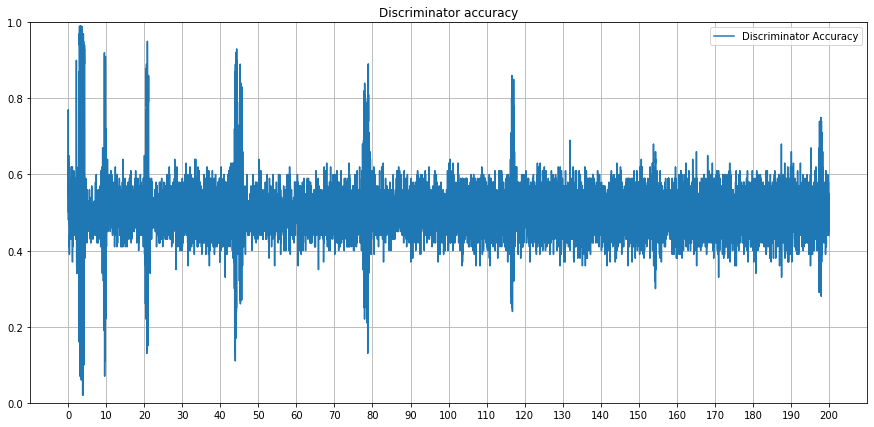

In [17]:
#discriminator accuracy
iter = 100
epochs = 200
d_acc = np.loadtxt('outputs/d_acc.txt')

plt.figure(figsize=(15,7))
plt.title('Discriminator accuracy')
plt.plot(d_acc, label='Discriminator Accuracy')
plt.xticks(np.arange(0, len(d_loss)+1, 10*iter), np.arange(0, epochs+1, 10))
plt.ylim(0, 1)
plt.legend()
plt.grid(True)
plt.show()

In [18]:
file = 'unweighted_events.lhe'
init, evs = readLHE.readEvent(file)

invar = np.zeros((len(evs),3))
for ev in range(len(evs)):
    invar[ev,0] = invariants.GetEnergySquared(evs[ev])
    invar[ev,1] = invariants.GetMandelT(evs[ev])
    invar[ev,2] = invariants.GetRapidity(init, evs[ev])

pred = np.loadtxt('outputs/pred.txt')

pred[:,0] = (1+pred[:,0])*(max(invar[:,0])-min(invar[:,0]))/2 + min(invar[:,0])
pred[:,1] = (1+pred[:,1])*(max(invar[:,1])-min(invar[:,1]))/2 + min(invar[:,1])
pred[:,2] = (1+pred[:,2])*(max(invar[:,2])-min(invar[:,2]))/2 + min(invar[:,2])

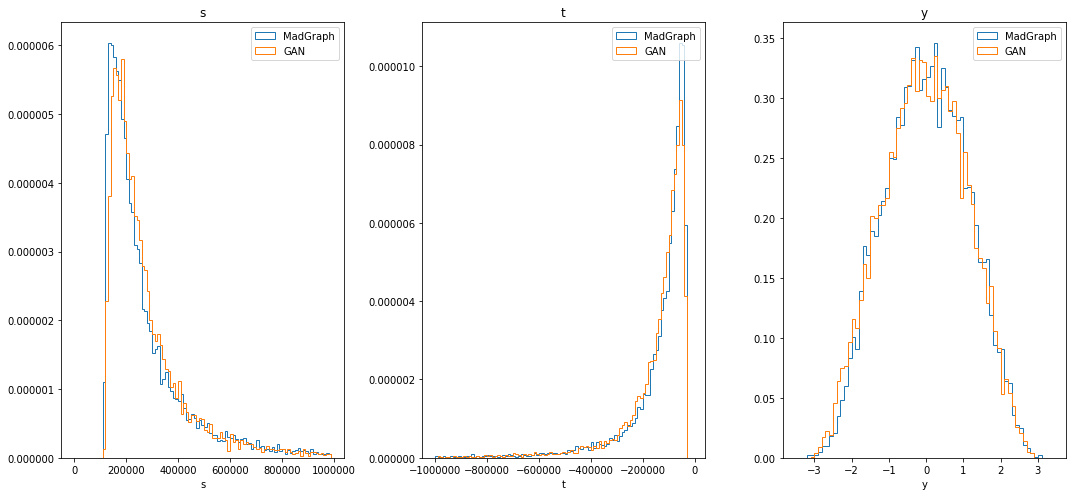

In [30]:
bins = [np.arange(0, 1e6, 1e4), np.arange(-1e6, 0, 1e4), np.arange(-3.5, 3.5, 0.1)]
labels = ['s', 't', 'y']
fig, ax = plt.subplots(1,3, figsize=(15,7))
for i in range(3):
    ax[i].hist(invar[:,i], bins=bins[i], histtype='step', label='MadGraph', density=True)
    ax[i].hist(pred[:,i], bins=bins[i], histtype='step', label='GAN', density=True)
    ax[i].set_title(labels[i])
    ax[i].set_xlabel(labels[i])
    ax[i].legend()
fig.tight_layout()